# Empirical examples of facility location problems

*Authors:* [Germano Barcelos](https://github.com/gegen07), [James Gaboardi](https://github.com/jGaboardi), [Levi J. Wolf](https://github.com/ljwolf), [Qunshan Zhao](https://github.com/qszhao)

This tutorial aims to show a facility location application. To achieve this goal the tuorial will solve mulitple real world facility location problems using a dataset describing an area of census tract 205, San Francisco. The general scenarios can be stated as: store sites should supply the demand in this census tract considering the distance between the two sets of sites: demand points and candidate supply sites. Four fundamental facility location models are utilized to highlight varying outcomes dependent on objectives: LSCP (Location Set Covering Problem), MCLP (Maximal Coverage Location Problem), P-Median and P-Center. For further information on these models, it's recommended to see the notebooks that explain more deeply about each one: [LSCP](./lscp.ipynb), [MCLP](./mclp.ipynb), [P-Median](./p-median.ipynb), [P-Center](./p-center.ipynb).

Also, this tutorial demonstrates the use of different solvers that [PULP](https://github.com/coin-or/pulp) supports.

In [1]:
%config InlineBackend.figure_format = "retina"
%load_ext watermark
%watermark

Last updated: 2023-12-10T13:35:40.591294-05:00

Python implementation: CPython
Python version       : 3.12.0
IPython version      : 8.18.0

Compiler    : Clang 15.0.7 
OS          : Darwin
Release     : 23.1.0
Machine     : x86_64
Processor   : i386
CPU cores   : 8
Architecture: 64bit



In [2]:
import geopandas
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib.lines as mlines
import matplotlib_scalebar
from matplotlib_scalebar.scalebar import ScaleBar
import numpy
import pandas
import pulp
import shapely
from shapely.geometry import Point
import spopt
import time
import warnings

%watermark -w
%watermark -iv

Watermark: 2.4.3

pulp               : 2.7.0
matplotlib         : 3.8.2
geopandas          : 0.14.1
numpy              : 1.26.2
pandas             : 2.1.3
shapely            : 2.0.2
spopt              : 0.5.1.dev53+g5cadae7
matplotlib_scalebar: 0.8.1



-------------------
We use 4 data files as input:
- `network_distance` is the distance between facility candidate sites calculated by ArcGIS Network Analyst Extension
- `demand_points` represents the demand points with some important features for the facility location problem like population
- `facility_points` represents the stores that are candidate facility sites
- `tract` is the polygon of census tract 205.

All datasets are online on this [repository](https://github.com/huanfachen/Open_source_location_cover_models/tree/master/Data/San_Francisco_store).

In [3]:
DIRPATH = "../spopt/tests/data/"

`network_distance` dataframe

In [4]:
network_distance = pandas.read_csv(
    DIRPATH + "SF_network_distance_candidateStore_16_censusTract_205_new.csv"
)
network_distance

,distance,name,DestinationName,demand
0,671.573346,Store_1,60750479.01,6540
1,1333.708063,Store_1,60750479.02,3539
2,1656.188884,Store_1,60750352.02,4436
3,1783.006047,Store_1,60750602.00,231
4,1790.950612,Store_1,60750478.00,7787
...,...,...,...,...
3275,19643.307257,Store_19,60816023.00,3204
3276,20245.369594,Store_19,60816029.00,4135
3277,20290.986235,Store_19,60816026.00,7887
3278,20875.680521,Store_19,60816025.00,5146


`demand_points` dataframe

In [5]:
demand_points = pandas.read_csv(
    DIRPATH + "SF_demand_205_centroid_uniform_weight.csv", index_col=0
)
demand_points = demand_points.reset_index(drop=True)
demand_points

,OBJECTID,ID,NAME,STATE_NAME,AREA,POP2000,HOUSEHOLDS,HSE_UNITS,BUS_COUNT,long,lat
0,1,6081602900,60816029.00,California,0.48627,4135,1679,1715,112,-122.488653,37.650807
1,2,6081602800,60816028.00,California,0.47478,4831,1484,1506,59,-122.483550,37.659998
2,3,6081601700,60816017.00,California,0.46393,4155,1294,1313,55,-122.456484,37.663272
3,4,6081601900,60816019.00,California,0.81907,9041,3273,3330,118,-122.434247,37.662385
4,5,6081602500,60816025.00,California,0.46603,5146,1459,1467,44,-122.451187,37.640219
...,...,...,...,...,...,...,...,...,...,...,...
200,204,6075011100,60750111.00,California,0.09466,5559,2930,3037,362,-122.418479,37.791082
201,205,6075012200,60750122.00,California,0.07211,7035,3862,4074,272,-122.417237,37.785728
202,206,6075017601,60750176.01,California,0.24306,5756,2437,2556,943,-122.410115,37.779459
203,207,6075017800,60750178.00,California,0.27882,5829,3115,3231,807,-122.405411,37.778934


`facility_points` dataframe

In [6]:
facility_points = pandas.read_csv(DIRPATH + "SF_store_site_16_longlat.csv", index_col=0)
facility_points = facility_points.reset_index(drop=True)
facility_points

,OBJECTID,NAME,long,lat
0,1,Store_1,-122.510018,37.772364
1,2,Store_2,-122.488873,37.753764
2,3,Store_3,-122.464927,37.774727
3,4,Store_4,-122.473945,37.743164
4,5,Store_5,-122.449291,37.731545
5,6,Store_6,-122.491745,37.649309
6,7,Store_7,-122.483182,37.701109
7,8,Store_11,-122.433782,37.655364
8,9,Store_12,-122.438982,37.719236
9,10,Store_13,-122.440218,37.745382


`study_area` dataframe

In [7]:
study_area = geopandas.read_file(DIRPATH + "ServiceAreas_4.shp").dissolve()
study_area

,geometry
0,"POLYGON ((-122.45299 37.63898, -122.45415 37.6..."


Plot `study_area`

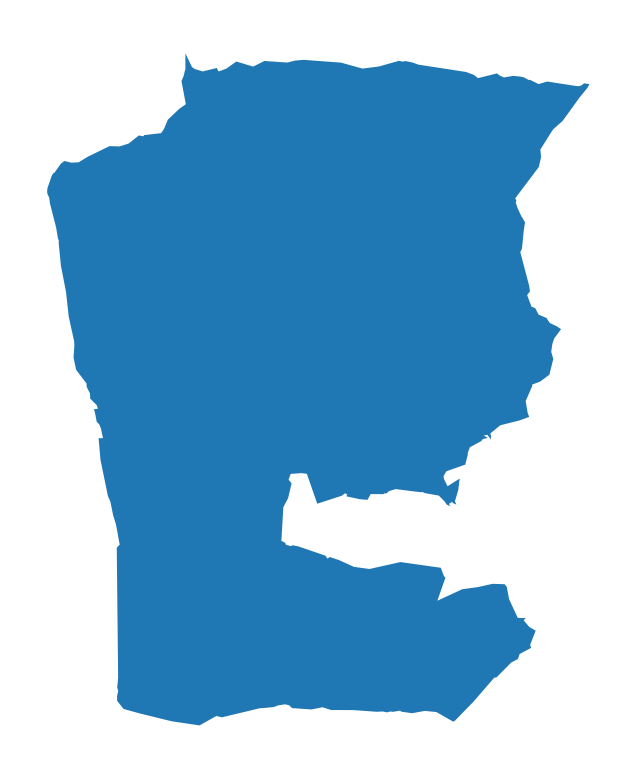

In [8]:
base = study_area.plot()
base.axis("off");

To start modeling the problem assuming the arguments expected by `spopt.locate`, we should pass a `numpy` 2D array as a cost matrix. So, first we pivot the network_distance dataframe. 

_Note that the columns and rows are sorted in ascending order._

In [9]:
ntw_dist_piv = network_distance.pivot_table(
    values="distance", index="DestinationName", columns="name"
)
ntw_dist_piv

name,Store_1,Store_11,Store_12,Store_13,Store_14,Store_15,Store_16,Store_17,Store_18,Store_19,Store_2,Store_3,Store_4,Store_5,Store_6,Store_7
DestinationName,,,,,,,,,,,,,,,,
60750101.0,11495.190454,20022.666503,10654.593733,8232.543149,7561.399789,4139.772198,4805.805279,2055.530234,225.609240,1757.623456,11522.519829,7529.985950,10847.234951,10604.729605,20970.277793,15242.989416
60750102.0,10436.169910,19392.094770,10024.022001,7601.971416,6930.828057,3093.851654,4175.233547,1257.809690,1041.911304,2333.244000,10509.099285,6470.965406,10216.663219,9974.157873,20339.706061,14612.417684
60750103.0,10746.296811,19404.672860,10036.600090,7614.549505,6943.406146,3381.778555,4187.811636,2046.436590,744.584403,1685.517099,10800.926186,6778.892307,10229.241308,9986.735962,20352.284150,14624.995773
60750104.0,11420.492134,19808.368182,10440.295413,8018.244828,7347.101469,4044.473877,4591.506959,2463.736278,795.715285,1282.217412,11308.221508,7447.187630,10632.936630,10390.431285,20755.979472,15028.691095
60750105.0,11379.443952,19583.920000,10215.847231,7793.796646,7122.653287,4103.725695,4367.058776,3320.283731,1731.462738,249.669959,11083.773326,7379.539448,10408.488448,10165.983103,20531.531290,14804.242913
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60816025.0,17324.066610,2722.031291,10884.063331,14178.007937,13891.857275,18418.384867,16726.951785,20834.395022,21441.247824,20875.680521,14662.484617,16569.371114,12483.322114,11926.727459,4968.842581,8648.054204
60816026.0,15981.172325,3647.137006,10299.369046,13593.313651,13307.162990,17833.690581,16142.257500,20249.700736,20856.553539,20290.986235,14050.290332,15963.776829,11871.527828,11342.033174,3625.948296,7919.659919
60816027.0,14835.342712,4581.333336,9637.139433,12931.084039,12644.933377,17171.460969,15480.027887,19587.471124,20194.323926,19628.756623,13341.313338,15301.547216,11209.298215,10679.803561,2290.818683,7242.830306


Here the pivot table is transformed to a numpy 2D array such as `spopt.locate` expected. The matrix has a shape of 205x16.

In [10]:
cost_matrix = ntw_dist_piv.to_numpy()
cost_matrix.shape

(205, 16)

In [11]:
cost_matrix[:3, :3]

array([[11495.19045438, 20022.66650296, 10654.59373325],
       [10436.16991032, 19392.09477041, 10024.0220007 ],
       [10746.29681106, 19404.67285964, 10036.60008993]])

Now, as the rows and columns of our cost matrix are sorted, we have to sort our facility points and demand points geodataframes, too. 

In [12]:
n_dem_pnts = demand_points.shape[0]
n_fac_pnts = facility_points.shape[0]

In [13]:
process = lambda df: as_gdf(df).sort_values(by=["NAME"]).reset_index(drop=True)
as_gdf = lambda df: geopandas.GeoDataFrame(df, geometry=pnts(df))
pnts = lambda df: geopandas.points_from_xy(df.long, df.lat)

In [14]:
facility_points = process(facility_points)
demand_points = process(demand_points)

Reproject the input spatial data.

In [15]:
for _df in [facility_points, demand_points, study_area]:
    _df.set_crs("EPSG:4326", inplace=True)
    _df.to_crs("EPSG:7131", inplace=True)

Here the rest of parameters are set.

`ai` is the demand weight and in this case we model as population in year 2000 of this tract.

In [16]:
ai = demand_points["POP2000"].to_numpy()

# maximum service radius (in meters)
SERVICE_RADIUS = 5000

# number of candidate facilities in optimal solution
P_FACILITIES = 4

Below, the method is used to plot the results of the four models that we will prepare to solve the problem.

In [17]:
dv_colors_arr = [
    "darkcyan",
    "mediumseagreen",
    "saddlebrown",
    "darkslategray",
    "lightskyblue",
    "thistle",
    "lavender",
    "darkgoldenrod",
    "peachpuff",
    "coral",
    "mediumvioletred",
    "blueviolet",
    "fuchsia",
    "cyan",
    "limegreen",
    "mediumorchid",
]
dv_colors = {f"y{i}": dv_colors_arr[i] for i in range(len(dv_colors_arr))}
dv_colors

{'y0': 'darkcyan',
 'y1': 'mediumseagreen',
 'y2': 'saddlebrown',
 'y3': 'darkslategray',
 'y4': 'lightskyblue',
 'y5': 'thistle',
 'y6': 'lavender',
 'y7': 'darkgoldenrod',
 'y8': 'peachpuff',
 'y9': 'coral',
 'y10': 'mediumvioletred',
 'y11': 'blueviolet',
 'y12': 'fuchsia',
 'y13': 'cyan',
 'y14': 'limegreen',
 'y15': 'mediumorchid'}

In [18]:
def plot_results(model, p, facs, clis=None, ax=None):
    """Visualize optimal solution sets and context."""
    if not ax:
        multi_plot = False
        fig, ax = plt.subplots(figsize=(6, 9))
        markersize, markersize_factor = 4, 4
    else:
        ax.axis("off")
        multi_plot = True
        markersize, markersize_factor = 2, 2
    ax.set_title(model.name, fontsize=15)

    # extract facility-client relationships for plotting (except for p-dispersion)
    plot_clis = isinstance(clis, geopandas.GeoDataFrame)
    if plot_clis:
        cli_points = {}
    fac_sites = {}
    for i, dv in enumerate(model.fac_vars):
        if dv.varValue:
            dv, predef = facs.loc[i, ["dv", "predefined_loc"]]
            fac_sites[dv] = [i, predef]
            if plot_clis:
                geom = clis.iloc[model.fac2cli[i]]["geometry"]
                cli_points[dv] = geom

    # study area and legend entries initialization
    study_area.plot(ax=ax, alpha=0.5, fc="tan", ec="k", zorder=1)
    _patch = Patch(alpha=0.5, fc="tan", ec="k", label="Dissolved Service Areas")
    legend_elements = [_patch]

    if plot_clis:
        # any clients that not asscociated with a facility
        if model.name.startswith("mclp"):
            c = "k"
            if model.n_cli_uncov:
                idx = [i for i, v in enumerate(model.cli2fac) if len(v) == 0]
                pnt_kws = dict(ax=ax, fc=c, ec=c, marker="s", markersize=7, zorder=2)
                clis.iloc[idx].plot(**pnt_kws)
            _label = f"Demand sites not covered ($n$={model.n_cli_uncov})"
            _mkws = dict(marker="s", markerfacecolor=c, markeredgecolor=c, linewidth=0)
            legend_elements.append(mlines.Line2D([], [], ms=3, label=_label, **_mkws))

    # all candidate facilities
    facs.plot(ax=ax, fc="brown", marker="*", markersize=80, zorder=8)
    _label = f"Facility sites ($n$={len(model.fac_vars)})"
    _mkws = dict(marker="*", markerfacecolor="brown", markeredgecolor="brown")
    legend_elements.append(mlines.Line2D([], [], ms=7, lw=0, label=_label, **_mkws))

    # facility-(client) symbology and legend entries
    zorder = 4
    for fname, (fac, predef) in fac_sites.items():
        cset = dv_colors[fname]
        if plot_clis:
            # clients
            geoms = cli_points[fname]
            gdf = geopandas.GeoDataFrame(geoms)
            gdf.plot(ax=ax, zorder=zorder, ec="k", fc=cset, markersize=100 * markersize)
            _label = f"Demand sites covered by {fname}"
            _mkws = dict(markerfacecolor=cset, markeredgecolor="k", ms=markersize + 7)
            legend_elements.append(
                mlines.Line2D([], [], marker="o", lw=0, label=_label, **_mkws)
            )
        # facilities
        ec = "k"
        lw = 2
        predef_label = "predefined"
        if model.name.endswith(predef_label) and predef:
            ec = "r"
            lw = 3
            fname += f" ({predef_label})"
        facs.iloc[[fac]].plot(
            ax=ax, marker="*", markersize=1000, zorder=9, fc=cset, ec=ec, lw=lw
        )
        _mkws = dict(markerfacecolor=cset, markeredgecolor=ec, markeredgewidth=lw)
        legend_elements.append(
            mlines.Line2D([], [], marker="*", ms=20, lw=0, label=fname, **_mkws)
        )
        # increment zorder up and markersize down for stacked client symbology
        zorder += 1
        if plot_clis:
            markersize -= markersize_factor / p

    if not multi_plot:
        # legend
        kws = dict(loc="upper left", bbox_to_anchor=(1.05, 0.7))
        plt.legend(handles=legend_elements, **kws)

-----------------------------------------

## LSCP

In [19]:
from spopt.locate import LSCP

lscp = LSCP.from_cost_matrix(cost_matrix, SERVICE_RADIUS)
lscp = lscp.solve(pulp.GLPK(msg=False))
lscp_objval = lscp.problem.objective.value()
lscp_objval

8

Define the decision variable names used for mapping.

In [20]:
facility_points["dv"] = lscp.fac_vars
facility_points["dv"] = facility_points["dv"].map(lambda x: x.name.replace("_", ""))
facility_points["predefined_loc"] = 0

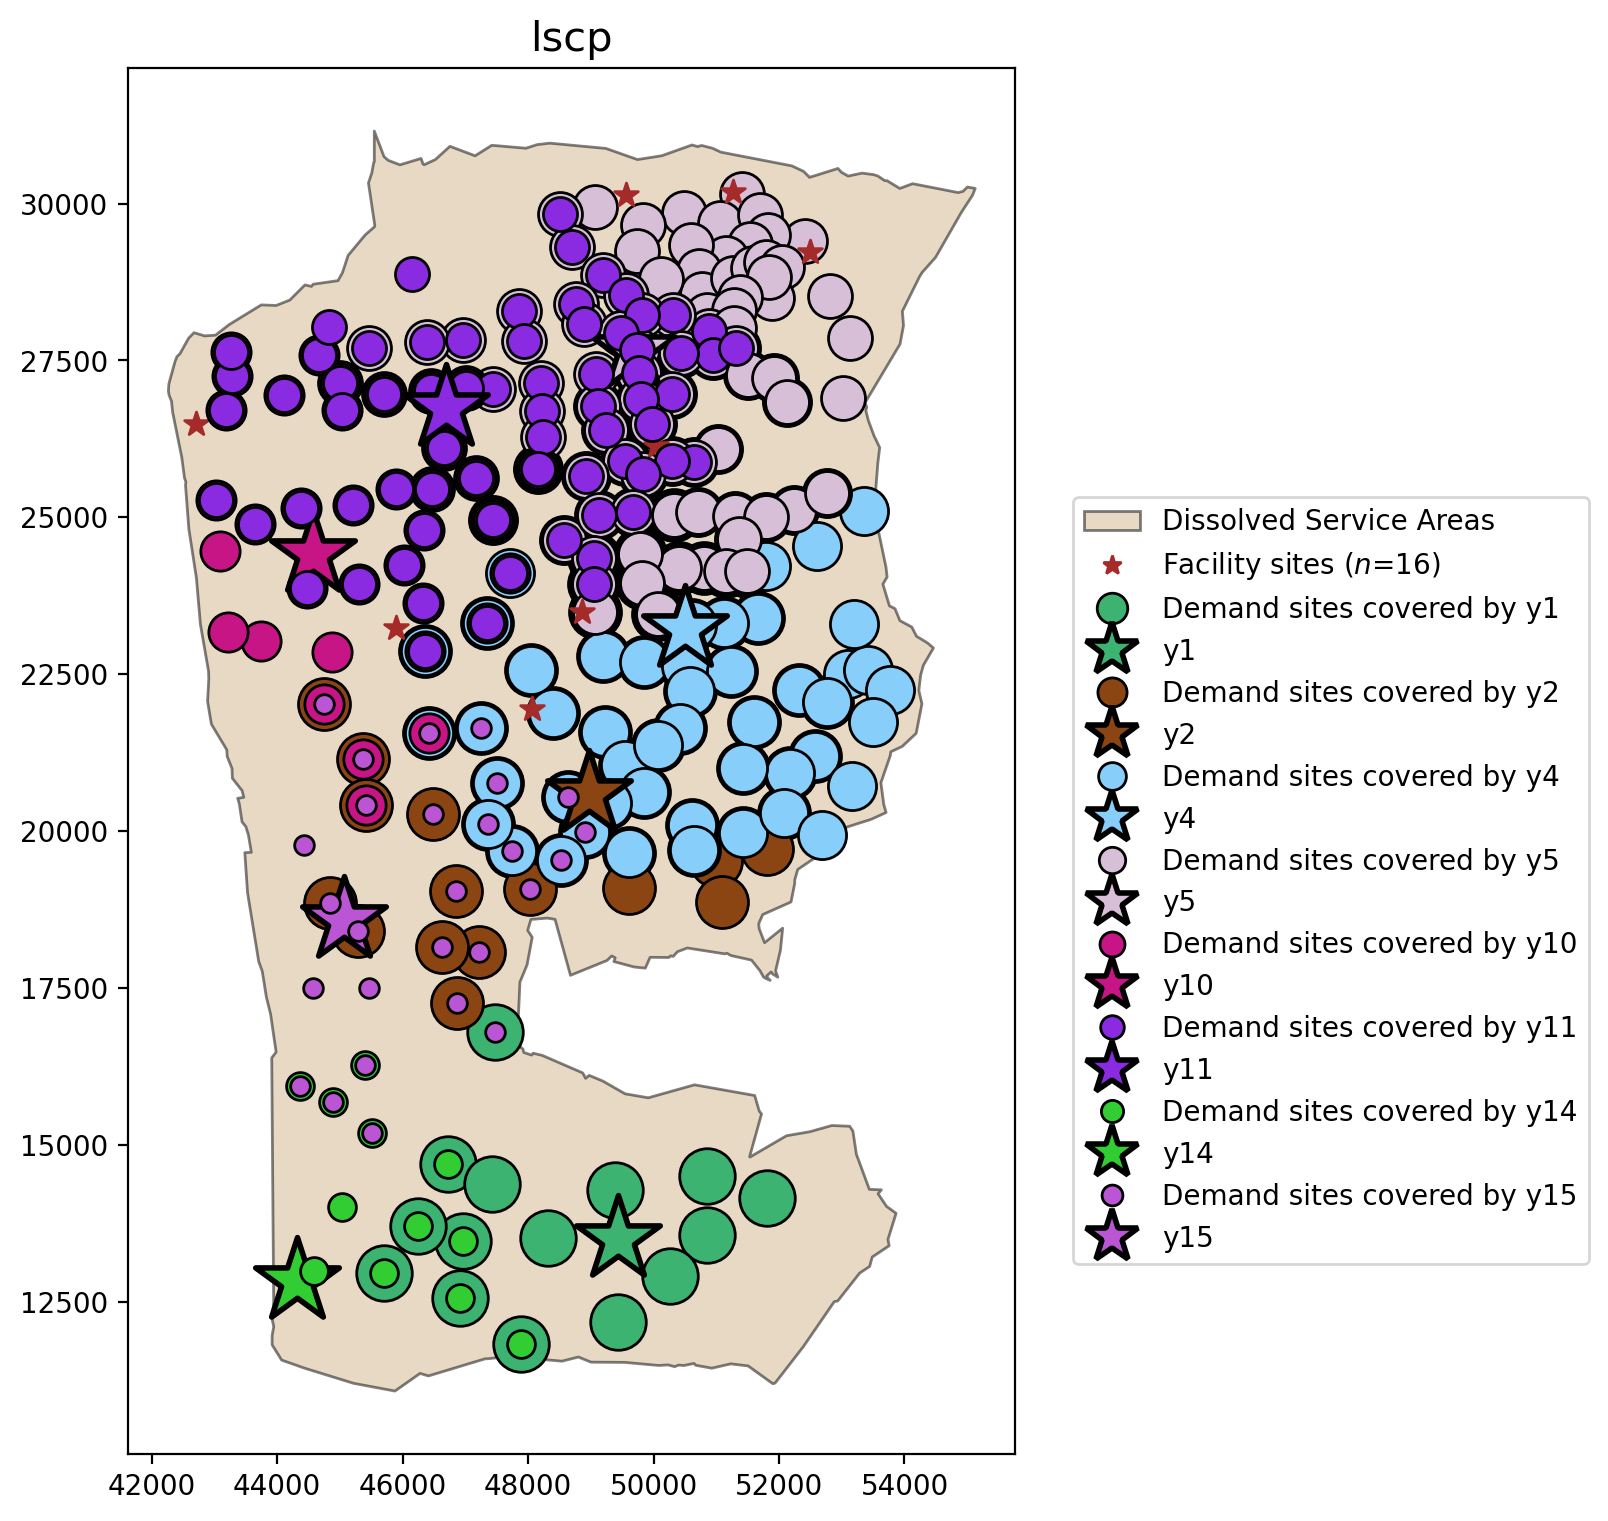

In [21]:
plot_results(lscp, lscp_objval, facility_points, clis=demand_points)

-----------------------------------------

## MCLP

In [22]:
from spopt.locate import MCLP

mclp = MCLP.from_cost_matrix(
    cost_matrix,
    ai,
    service_radius=SERVICE_RADIUS,
    p_facilities=P_FACILITIES,
)
mclp = mclp.solve(pulp.GLPK(msg=False))
mclp.problem.objective.value()

875247

MCLP Percentage Covered

In [23]:
mclp.perc_cov

89.75609756097562

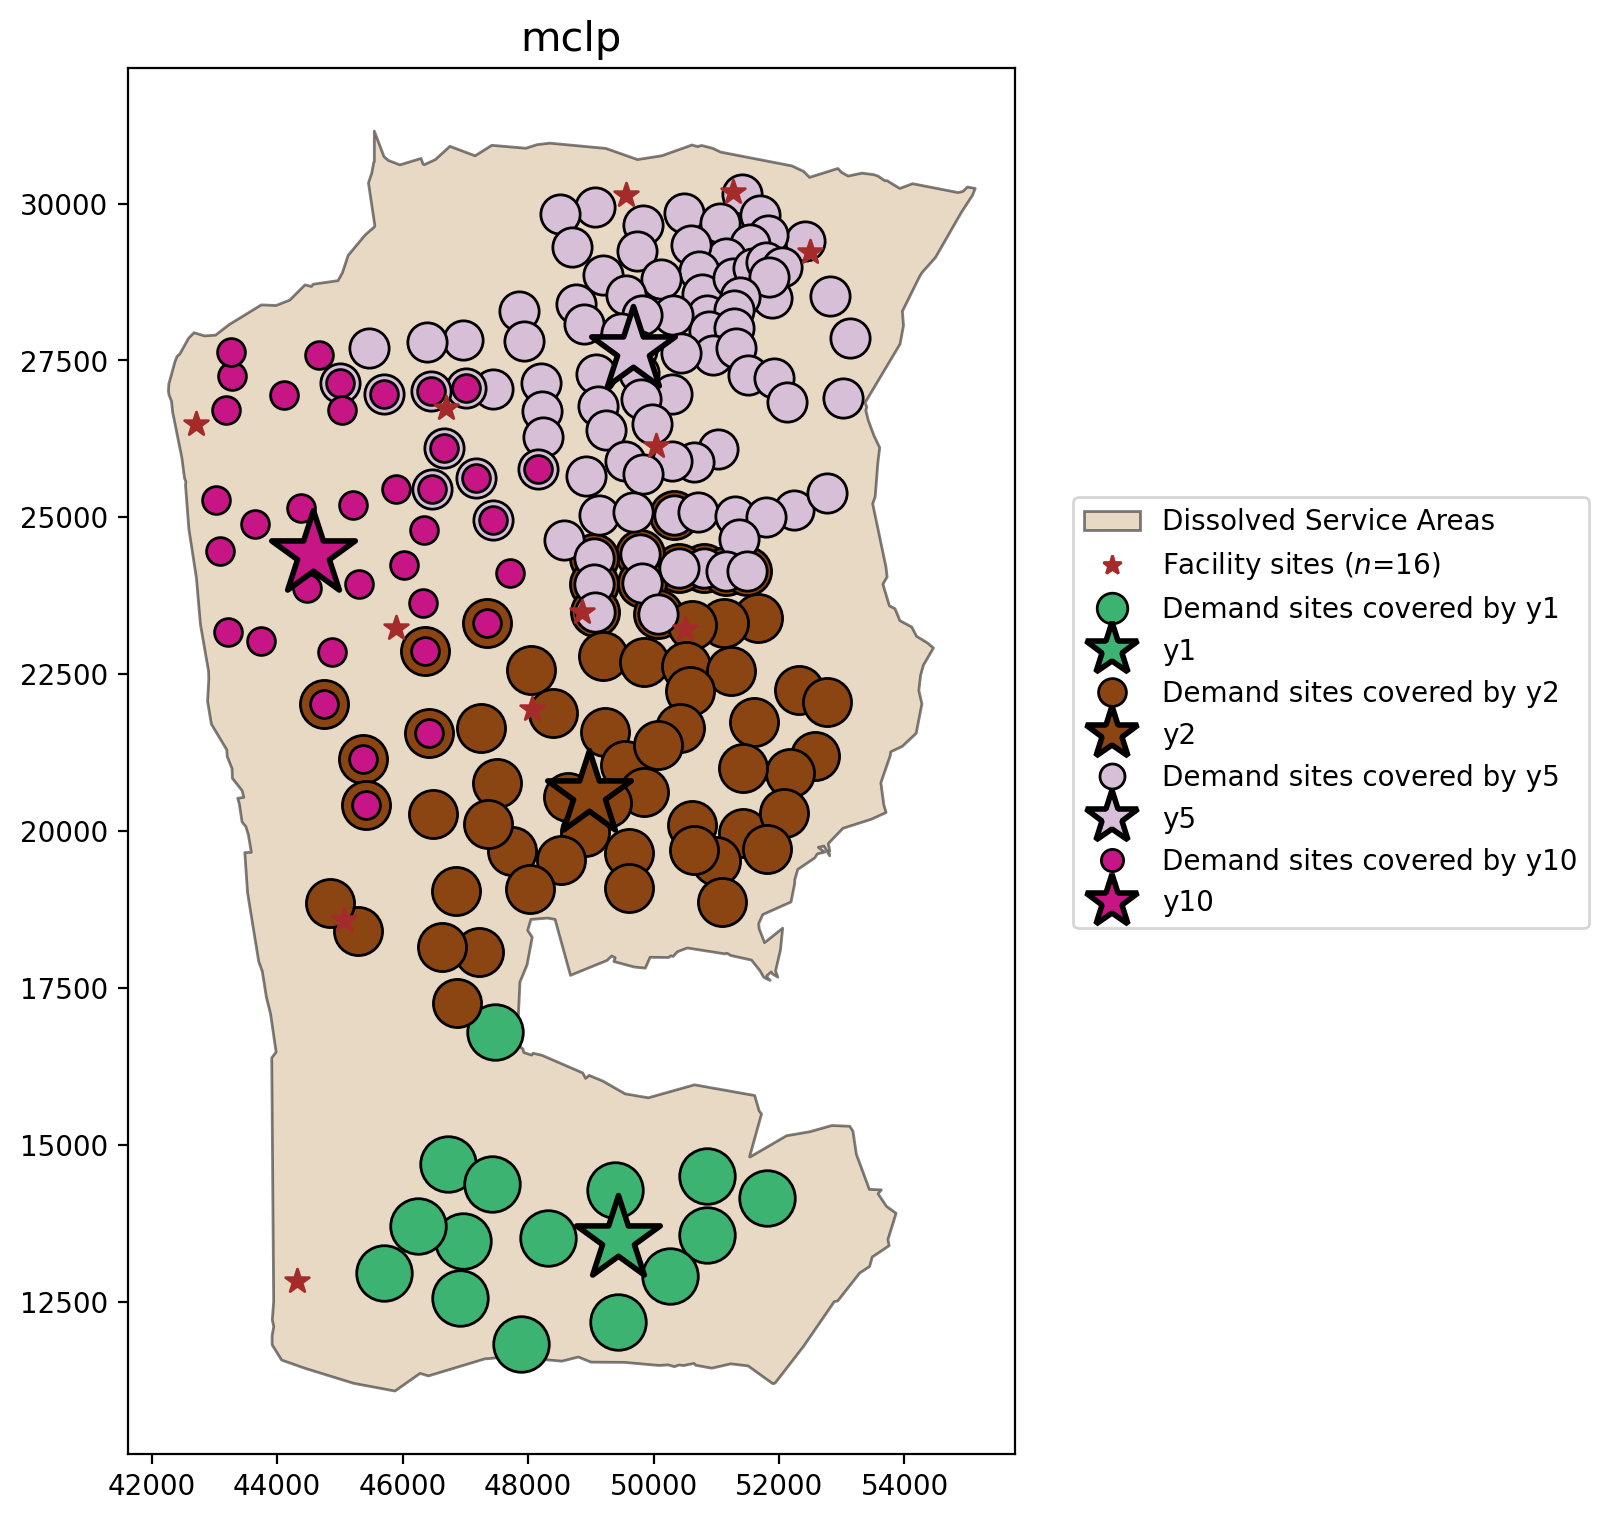

In [24]:
plot_results(mclp, P_FACILITIES, facility_points, clis=demand_points)

-------------------------------------------------
## P-Median

In [25]:
from spopt.locate import PMedian

pmedian = PMedian.from_cost_matrix(cost_matrix, ai, p_facilities=P_FACILITIES)
pmedian = pmedian.solve(pulp.GLPK(msg=False))
pmedian.problem.objective.value()

2848268129.7145104

$p$-median mean weighted distance

In [26]:
pmedian.mean_dist

2982.1268579890657

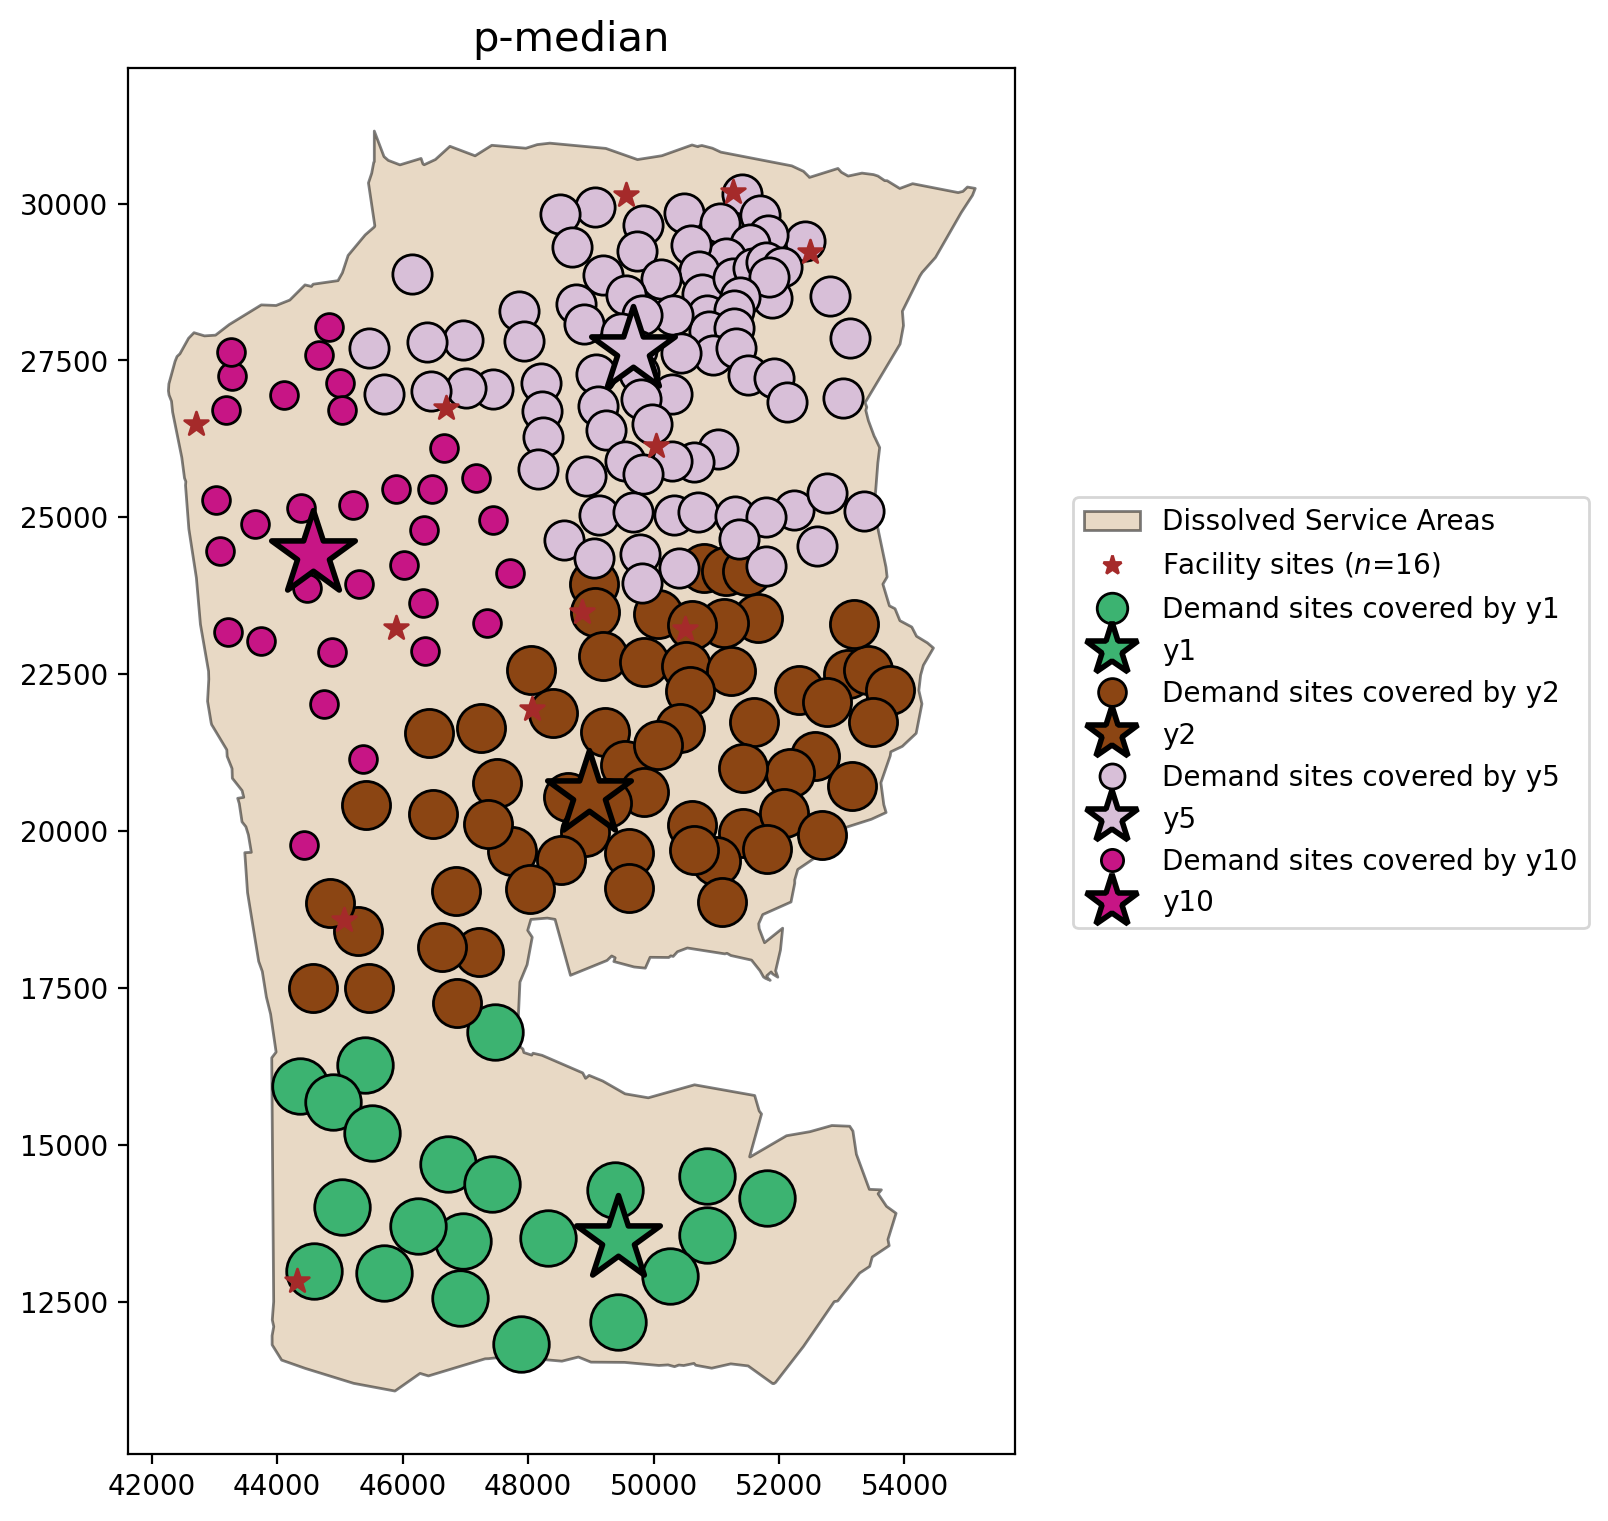

In [27]:
plot_results(pmedian, P_FACILITIES, facility_points, clis=demand_points)

--------------------------------


## P-Center

In [28]:
from spopt.locate import PCenter

pcenter = PCenter.from_cost_matrix(cost_matrix, p_facilities=P_FACILITIES)
pcenter = pcenter.solve(pulp.GLPK(msg=False))
pcenter.problem.objective.value()

7403.06

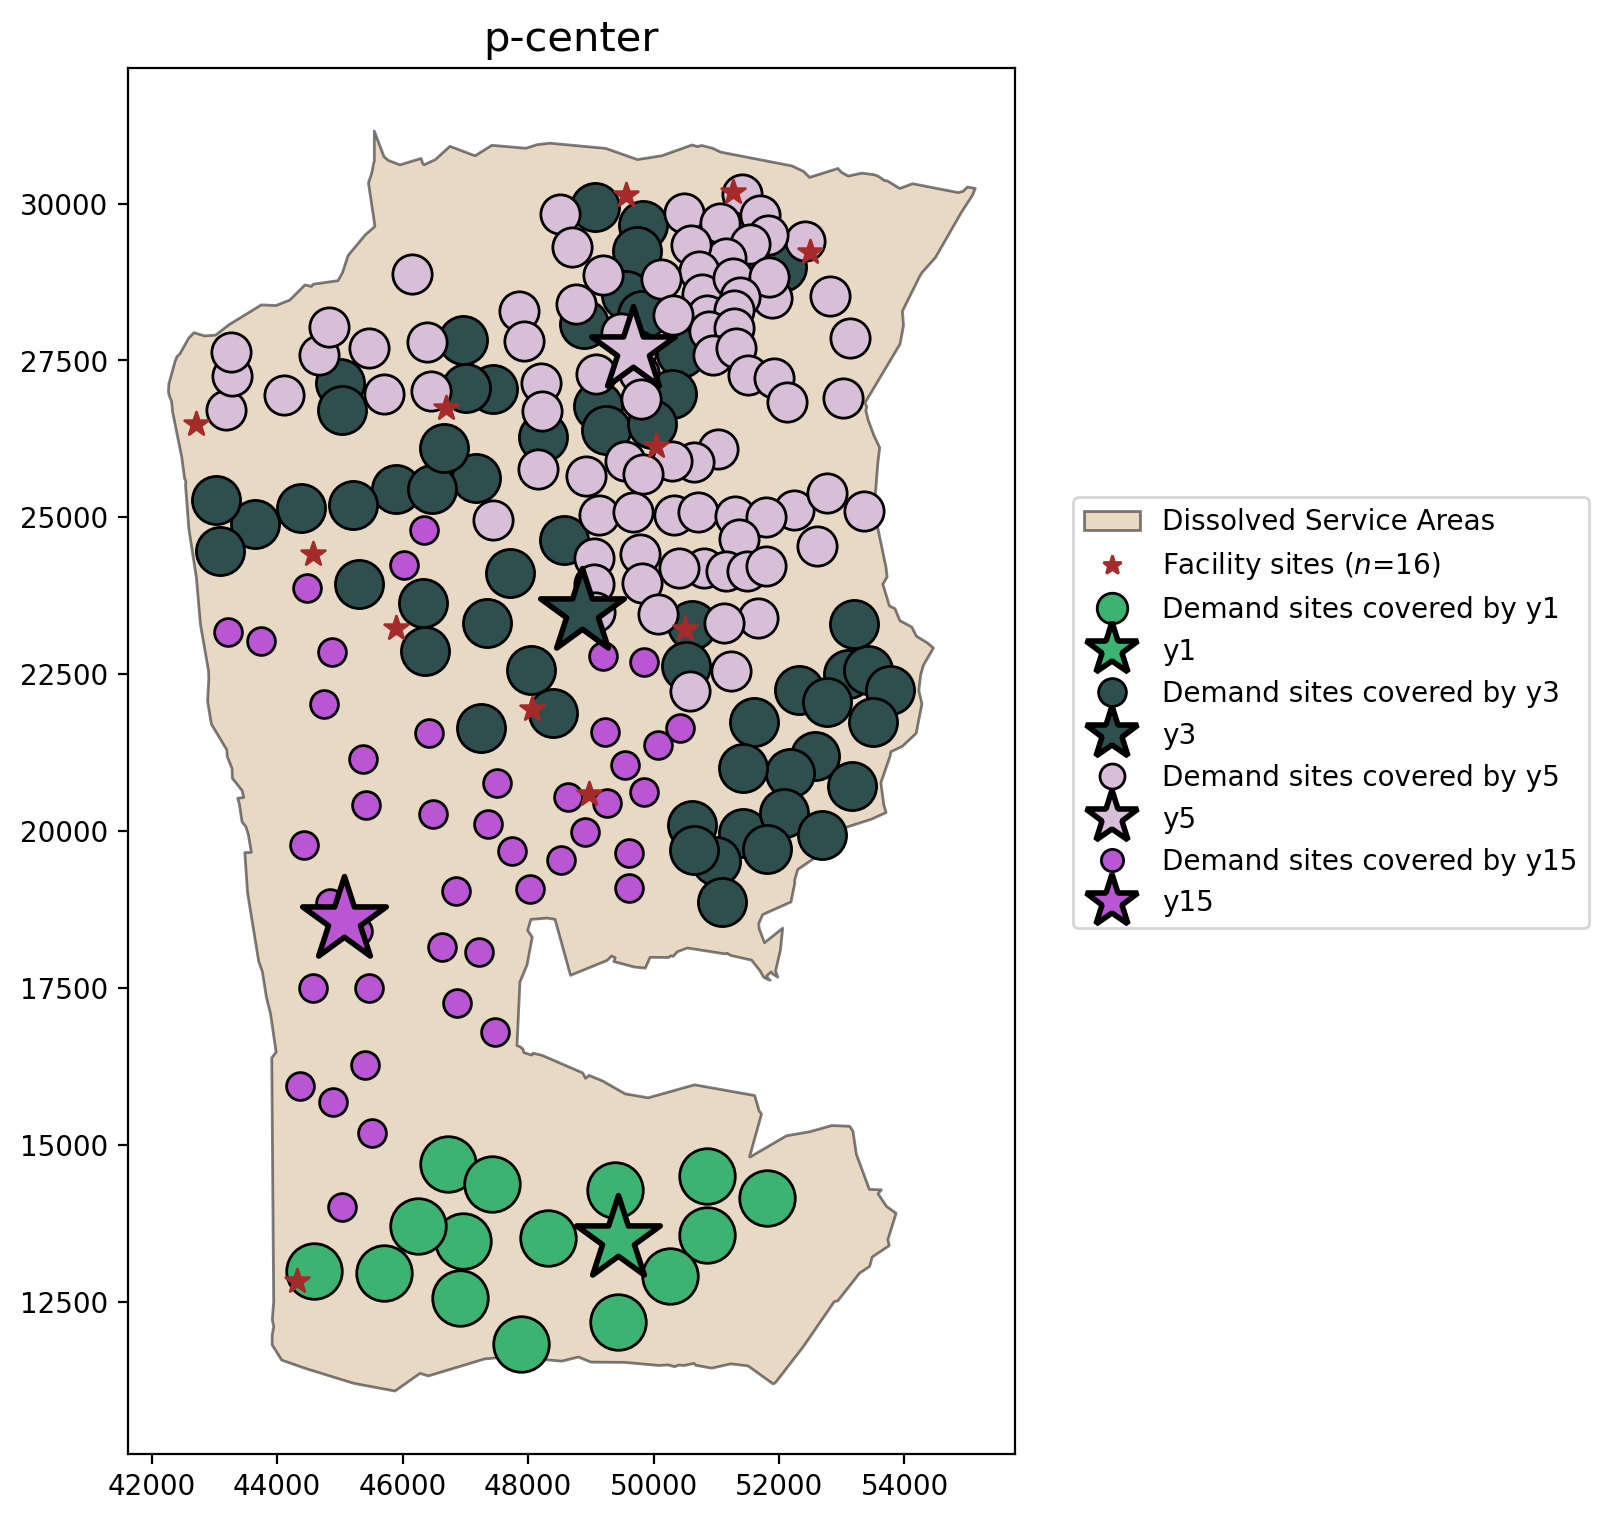

In [29]:
plot_results(pcenter, P_FACILITIES, facility_points, clis=demand_points)

-----------------------------------

## Comparing all models

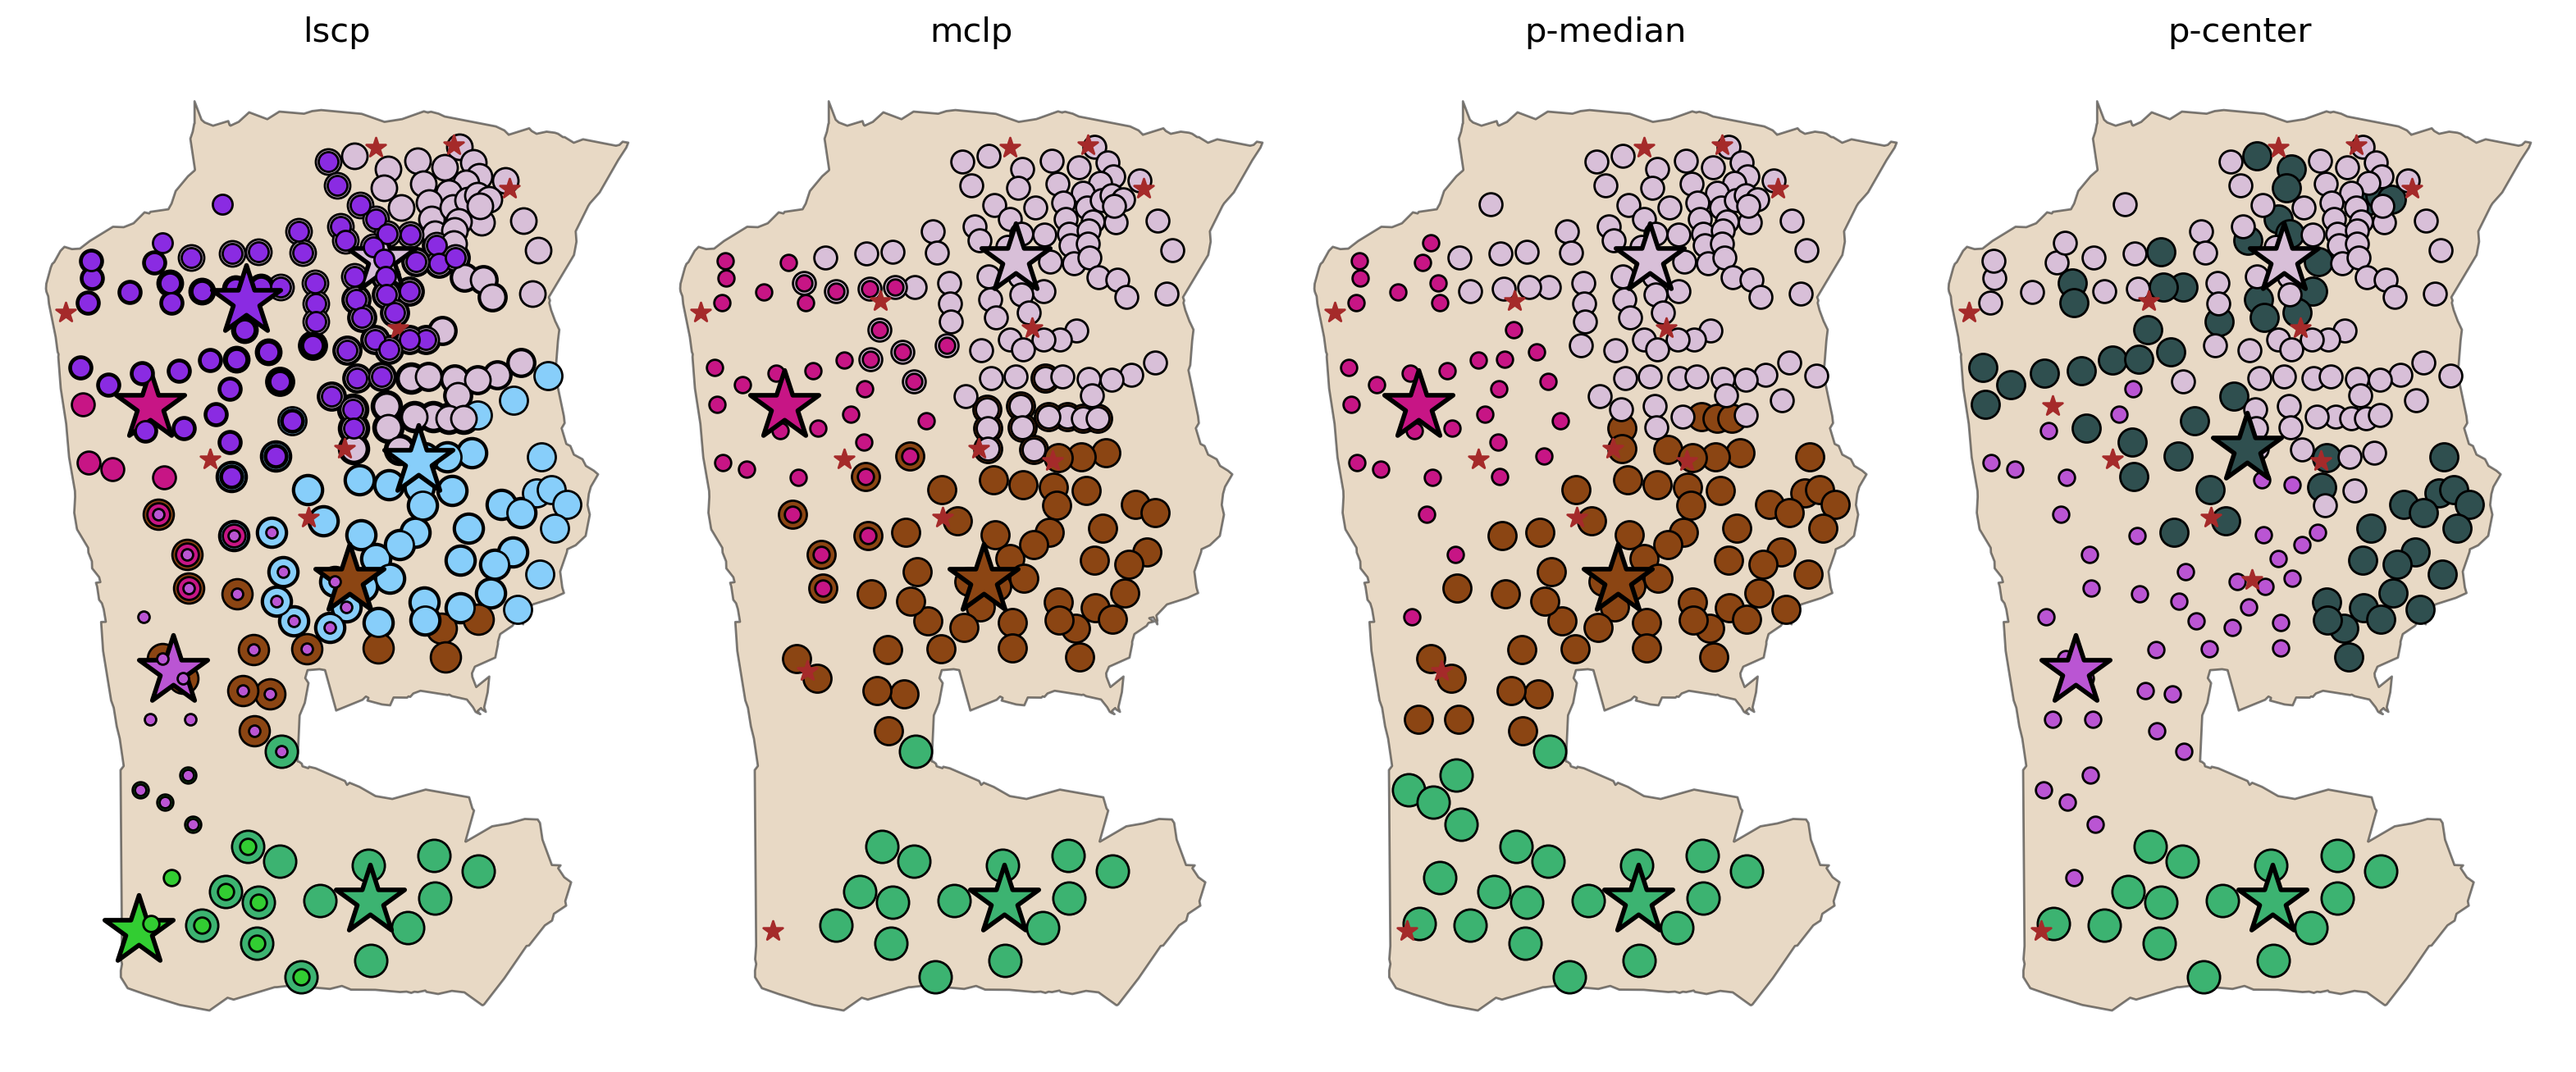

In [30]:
fig, axarr = plt.subplots(1, 4, figsize=(20, 10))
fig.subplots_adjust(wspace=-0.01)
for i, m in enumerate([lscp, mclp, pmedian, pcenter]):
    _p = m.problem.objective.value() if m.name == "lscp" else P_FACILITIES
    plot_results(m, _p, facility_points, clis=demand_points, ax=axarr[i])

The plot above clearly demonstrates the key features of each location model:
* LSCP
  * Overlapping clusters of clients associated with multiple facilities
  * All clients covered by at least one facility
* MCLP
  * Overlapping clusters of clients associated with multiple facilities
  * Potential for complete coverage, but not guranteed
* $p$-median
  * Tight and distinct clusters of client-facility relationships
  * All clients allocated to exactly one facility
* $p$-center
  * Loose and overlapping clusters of client-facility relationships
  * All clients allocated to exactly one facility 

----------------------------------------

## Evaluating available solvers

For this task we'll solve the MCLP and $p$-center models as examples of solver performance, but first we'll determine which solvers are installed locally.

In [31]:
with warnings.catch_warnings(record=True) as w:
    solvers = pulp.listSolvers(onlyAvailable=True)
for _w in w:
    print(_w.message)
solvers

GUROBI error: 
Failed to set up a license

Error 10009: License expired 2022-08-07


.


['GLPK_CMD', 'CPLEX_CMD', 'PULP_CBC_CMD', 'COIN_CMD', 'SCIP_CMD', 'HiGHS_CMD']

Above we can see that it returns a list with different solvers that are available. So, it's up to the user to choose the best solver that fits the model. 

### MCLP

Let's get the percentage as a metric to evaluate which solver is the best or improves the model.

In [32]:
mclp = MCLP.from_cost_matrix(
    cost_matrix,
    ai,
    service_radius=SERVICE_RADIUS,
    p_facilities=P_FACILITIES,
)

In [33]:
results = pandas.DataFrame(columns=["Coverage %", "Solve Time (sec.)"], index=solvers)
for solver in solvers:
    if solver == "HiGHS_CMD":
        # HiGHS doesn't directly support maximization
        with warnings.catch_warnings(record=True) as w:
            _mclp = mclp.solve(pulp.get_solver(solver, msg=False))
        print(w[0].message)
    else:
        _mclp = mclp.solve(pulp.get_solver(solver, msg=False))
    results.loc[solver] = [_mclp.perc_cov, _mclp.problem.solutionTime]
results

HiGHS_CMD does not currently allow maximization, we will minimize the inverse of the objective function.


,Coverage %,Solve Time (sec.)
GLPK_CMD,89.756098,0.027721
CPLEX_CMD,89.756098,0.041584
PULP_CBC_CMD,89.756098,0.030322
COIN_CMD,89.756098,0.041051
SCIP_CMD,89.756098,0.043232
HiGHS_CMD,89.756098,0.030545


As is expected from such a small model the **Coverage %**, and thus the obejective values, are equivalent for all solutions across solvers. However, solve times do vary slightly.

### P-Center

In [34]:
pcenter = PCenter.from_cost_matrix(cost_matrix, p_facilities=P_FACILITIES)

In [35]:
results = pandas.DataFrame(columns=["MinMax", "Solve Time (sec.)"], index=solvers)
for solver in solvers:
    _pcenter = pcenter.solve(pulp.get_solver(solver, msg=False))
    results.loc[solver] = [
        _pcenter.problem.objective.value(),
        _pcenter.problem.solutionTime,
    ]
results

,MinMax,Solve Time (sec.)
GLPK_CMD,7403.06,23.979474
CPLEX_CMD,7403.063811,0.739071
PULP_CBC_CMD,7403.0638,1.751734
COIN_CMD,7403.0638,1.821592
SCIP_CMD,7403.063811,6.797391
HiGHS_CMD,7403.063811,2.603489


Here the **MinMax** objective values are mostly equivalent, but there are some precision concerns. This is due to the computational complexity of the $p$-center problem, which also results in dramaticaly longer run times needed to isolate the optimal solutions (when compared with the MCLP above).

-----------------------